# __Xente Fraud Detection Challenge__

Our goal: Accurately classify the fraudulent transactions from Xente's e-commerce platform.

# Intro

Xente is an e-commerce and financial service app serving 10,000+ customers in Uganda.

This dataset includes a sample of approximately 140,000 transactions that occurred between 15 November 2018 and 15 March 2019.

# Load the data set

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from sklearn.utils import resample

RSEED = 25

In [2]:
# Xente variable definitions
variable_def =pd.read_csv('data/Xente_Variable_Definitions.csv')
variable_def

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


The data is split into test and train already:

In [3]:
test_raw =pd.read_csv('data/test.csv')
train_raw =pd.read_csv('data/training.csv')

In [4]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45019 entries, 0 to 45018
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         45019 non-null  object 
 1   BatchId               45019 non-null  object 
 2   AccountId             45019 non-null  object 
 3   SubscriptionId        45019 non-null  object 
 4   CustomerId            45019 non-null  object 
 5   CurrencyCode          45019 non-null  object 
 6   CountryCode           45019 non-null  int64  
 7   ProviderId            45019 non-null  object 
 8   ProductId             45019 non-null  object 
 9   ProductCategory       45019 non-null  object 
 10  ChannelId             45019 non-null  object 
 11  Amount                45019 non-null  float64
 12  Value                 45019 non-null  int64  
 13  TransactionStartTime  45019 non-null  object 
 14  PricingStrategy       45019 non-null  int64  
dtypes: float64(1), int6

In [5]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

The final submission result should be showing the transaction id of the test data set and the predicted result of whether it is fraudulent or not:

In [6]:
sample_submission =pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(45019, 2)


,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


- Training.csv: Transactions from 15 November 2018 to 13 February 2019, including whether or not each transaction is fraudulent. We will use this file to train our model.
- Test.csv: Transactions from 13 February 2019 to 14 March 2019, not including whether or not each transaction is fraudulent. We will test our model on this file.

In [7]:
test_raw.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy'],
      dtype='object')

In [8]:
train_raw.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

One of the challenges of fraud detection problems is that the data is highly imbalanced:

In [9]:
train_raw.groupby('FraudResult').size()

FraudResult
0    95469
1      193
dtype: int64

In [10]:
train_raw.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# A closer look at the fraudulent incidences

In [11]:
# Create a dataframe for fraud cases
fraud_raw = train_raw[train_raw['FraudResult'] == 1]

# Number of unique features that are fraudulent compared to the train dataset
print("Number of fraudulent Batches:", fraud_raw['BatchId'].nunique())
print('\n')
print("Number of fraudulent Accounts:", fraud_raw['AccountId'].nunique())
print("Number of fraudulent Subscriptions:", fraud_raw['SubscriptionId'].nunique())
print("Number of fraudulent Customers:", fraud_raw['CustomerId'].nunique())
print('\n')
print("Number of fraudulent Providers:", fraud_raw['ProviderId'].nunique())
print("Number of all Providers:", train_raw['ProviderId'].nunique())
print('\n')
print("Number of fraudulent Products:", fraud_raw['ProductId'].nunique())
print("Number of all Products:", train_raw['ProductId'].nunique())
print('\n')
print("Number of fraudulent Product Category:", fraud_raw['ProductCategory'].nunique())
print("Number of all Product Category:", train_raw['ProductCategory'].nunique())
print('\n')
print("Number of fraudulent Channels:", fraud_raw['ChannelId'].nunique())
print("Number of all Channels:", train_raw['ChannelId'].nunique())
print('\n')
print("Number of fraudulent Pricing Strategies:", fraud_raw['PricingStrategy'].nunique())
print("Number of all Pricing Strategies:", train_raw['PricingStrategy'].nunique())


Number of fraudulent Batches: 183


Number of fraudulent Accounts: 52
Number of fraudulent Subscriptions: 52
Number of fraudulent Customers: 54


Number of fraudulent Providers: 5
Number of all Providers: 6


Number of fraudulent Products: 9
Number of all Products: 23


Number of fraudulent Product Category: 4
Number of all Product Category: 9


Number of fraudulent Channels: 3
Number of all Channels: 4


Number of fraudulent Pricing Strategies: 4
Number of all Pricing Strategies: 4


From above, the batchid doesnt seem a good feature to use. The account/subscription/customer show that the same account/subscription/customer tend to fraud more than once, therefore creating a boolean of whether the account has a fraud history could be a good indicator of fraud prediction. The product and product category seem to centralise more on certain categories, making them possible indicators of fraud as well. 

<AxesSubplot:>

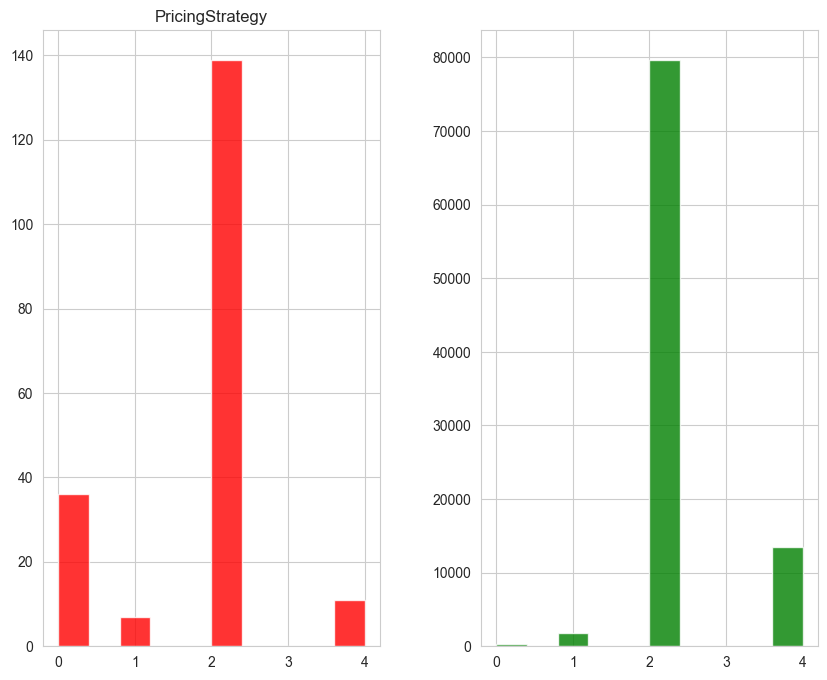

In [12]:
# Plot distributions of features and compare between fraud and non-fraud side by side

fig, axes = plt.subplots(1, 2)

fraud_raw.hist('PricingStrategy', color='red', alpha=0.8, ax=axes[0])
train_raw[train_raw['FraudResult']==0]['PricingStrategy'].hist(color='green', label='FraudResult: 1', alpha=0.8, ax=axes[1])

Pricing strategy doesnt seem to be systematically different for fraud and non-fraud cases.

# Data cleaning and feature engineering

### Feature engineering #1: Value catogory - large or small

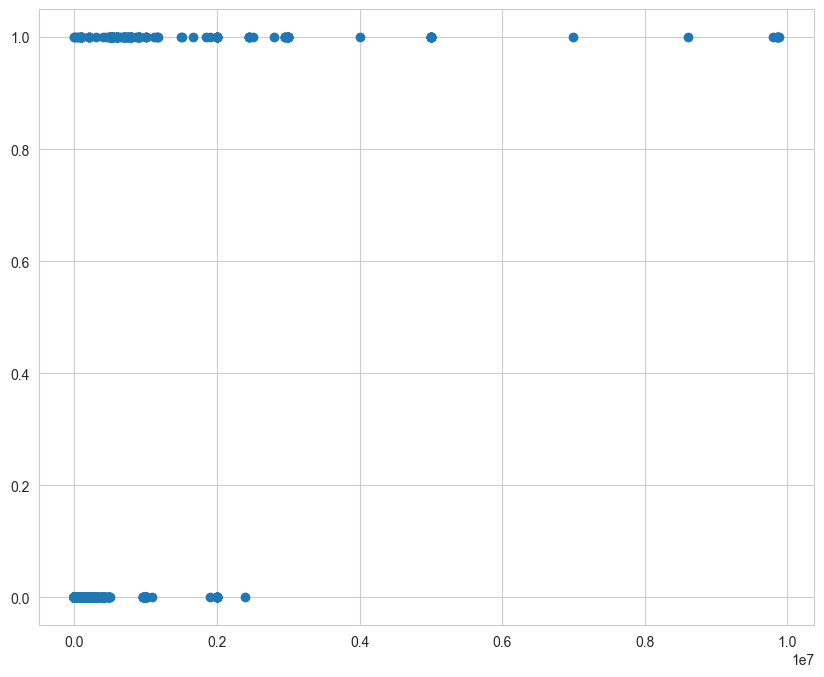

In [13]:
# Plot the value and compare fraud and non fraud values

train_raw_value = train_raw.Value
FraudResult_raw = train_raw.FraudResult

plt.scatter(train_raw_value,FraudResult_raw)
plt.show()

It shows that when the value is above a certain threshold, all the cases are fraudulent.

In [14]:
# Get the maximum value for a non-fraudulent transaction to determine the threshold for 
# whether the transaction value is "large" or "small".

train_raw[(train_raw.FraudResult == 0)]['Value'].max()

2400000

In [15]:
# Create a new dummy feature 'Value_cat' based on the above threshold.

train_raw['Value_cat'] = pd.cut(train_raw['Value'], bins=[0, 2400000, float('Inf')], labels=[0, 1])

# 0 - small
# 1 - large

In [16]:
train_raw.groupby('Value_cat').count()['TransactionId']

Value_cat
0    95621
1       41
Name: TransactionId, dtype: int64

The new categorical feature "Value_cat" divides the transaction value into either "large" or "small". All 41 large transactions are fraudulent, which makes "Value_cat" a factor to determine fraud.

### Feature engineering #2: direction of transaction (incoming/outgoing)

In [17]:
# Create a new feature 'trans_direction' based on whether it is negative or positive


train_raw['trans_direction'] = 1
train_raw.loc[(train_raw['Amount'] >= 0), 'trans_direction'] = 0

# 1 - outgoing
# 2 - incoming

In [18]:
train_raw[(train_raw.FraudResult == 1)].groupby('trans_direction').count()['TransactionId']

trans_direction
0    188
1      5
Name: TransactionId, dtype: int64

In [19]:
train_raw[(train_raw.FraudResult == 0)].groupby('trans_direction').count()['TransactionId']

trans_direction
0    57285
1    38184
Name: TransactionId, dtype: int64

We can see that the fraudulent transactions are significantly more in incoming direction than outgoing, therefore this feature should be a good indicator for fraud detection.

### Feature engineering #3: account fraud history (True/False)

Accounts with a fraud history is high risk account and should be marked in the dataset.

In [20]:
# Create a history data frame to store the account id and the fraud result 
history = train_raw.groupby(by= 'AccountId')['FraudResult'].max().reset_index()
history_dict = {}

# For loop 
for idx, x in history.iterrows():
    history_dict[x[0]] = x[1]

In [21]:
train_raw['fraud_history'] = train_raw.AccountId

In [22]:
train_raw['fraud_history'] = train_raw['fraud_history'].map(history_dict)

Now we updated a new boolean column which is 1 when the account is ever fraudulent and 0 otherwise.

In [23]:
# code snippet using sql

# select accountid, 
# case when accountid in (
# select distint accountid from train_raw where fraudresult = 1) then 1
# else 0 end as fraud_history
# from train_raw

### Feature engineering #4: transaction hour of day & day of week

It is likely that fraudulent cases happen at certain hours of a day or days of a week.

In [24]:
train_raw['TransactionStartTime']= pd.to_datetime(train_raw['TransactionStartTime'])
fraud_raw['TransactionStartTime']= pd.to_datetime(fraud_raw['TransactionStartTime'])

In [25]:
from datetime import datetime 

# Hour of day
train_raw['Transaction_hour'] = train_raw['TransactionStartTime'].dt.strftime("%H").astype(str).astype(int)
fraud_raw['Transaction_hour'] = fraud_raw['TransactionStartTime'].dt.strftime("%H").astype(str).astype(int)

# Day of week
train_raw['Transaction_weekday'] = train_raw['TransactionStartTime'].dt.strftime("%u").astype(str).astype(int)
fraud_raw['Transaction_weekday'] = fraud_raw['TransactionStartTime'].dt.strftime("%u").astype(str).astype(int)


<AxesSubplot:ylabel='Frequency'>

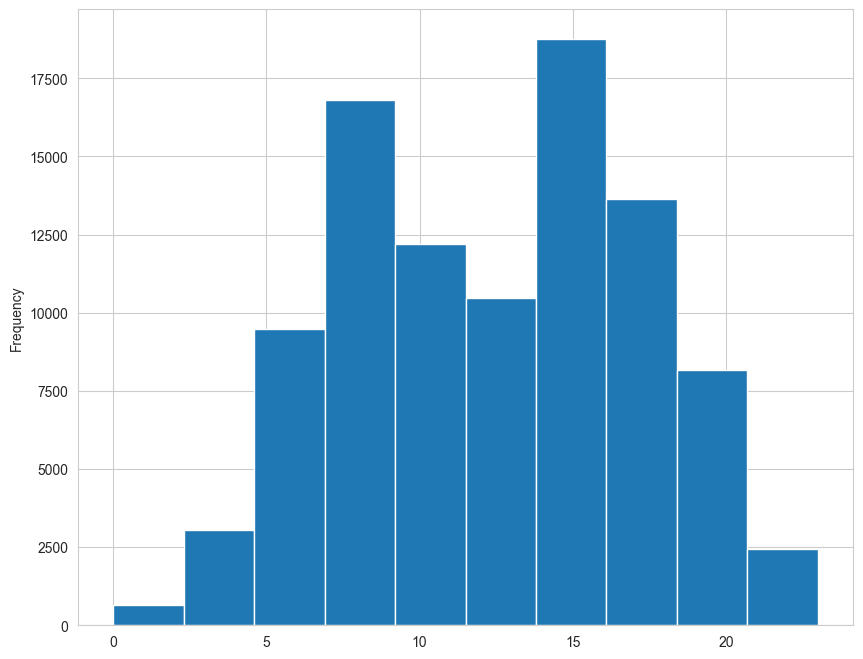

In [26]:
train_raw.Transaction_hour.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

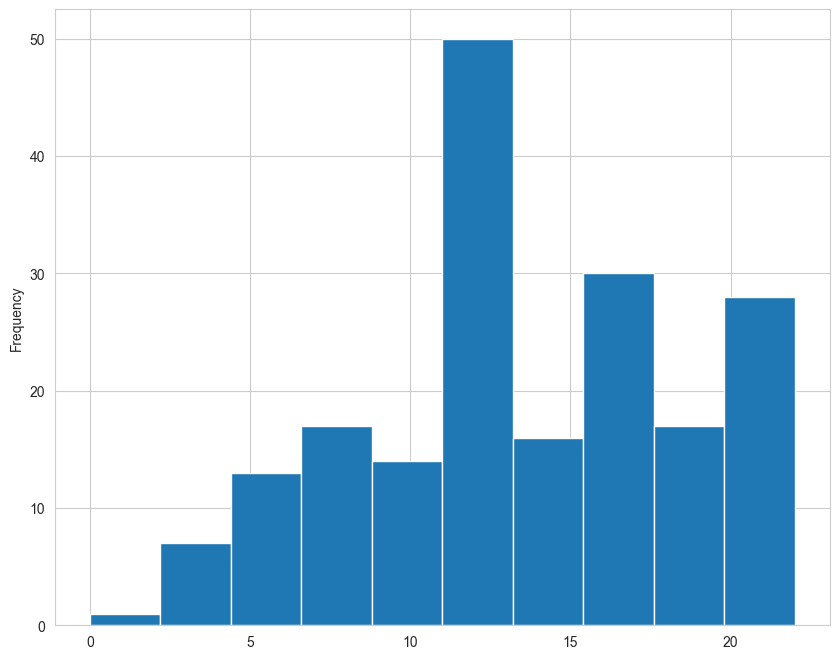

In [27]:
fraud_raw.Transaction_hour.plot(kind='hist')

In [28]:
fraud_raw.groupby('Transaction_hour').count()['TransactionId']

Transaction_hour
0      1
3      7
5      6
6      7
7      9
8      8
9     10
10     4
11     9
12    24
13    17
14     8
15     8
16    18
17    12
18    13
19     4
20     9
21    15
22     4
Name: TransactionId, dtype: int64

<AxesSubplot:ylabel='Frequency'>

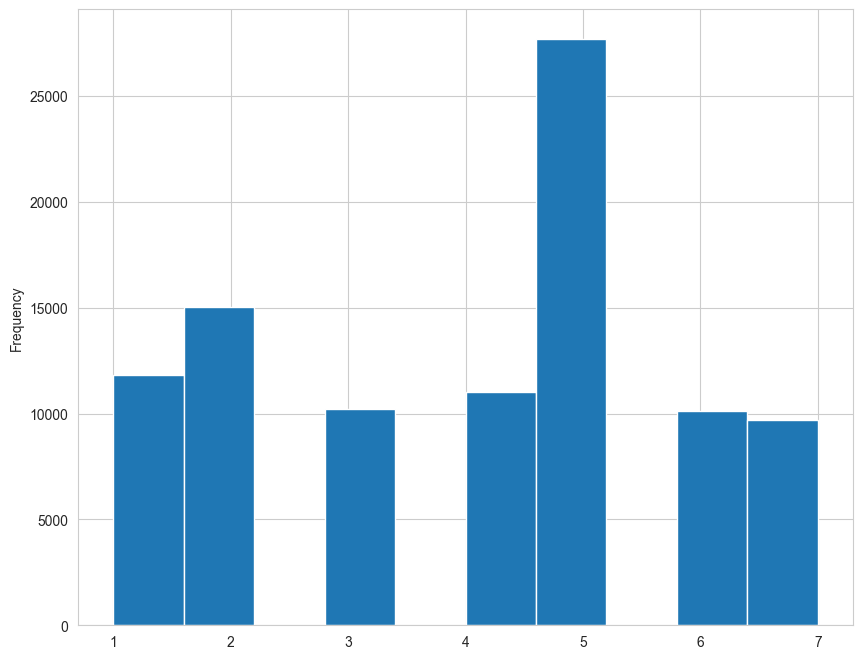

In [29]:
train_raw.Transaction_weekday.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

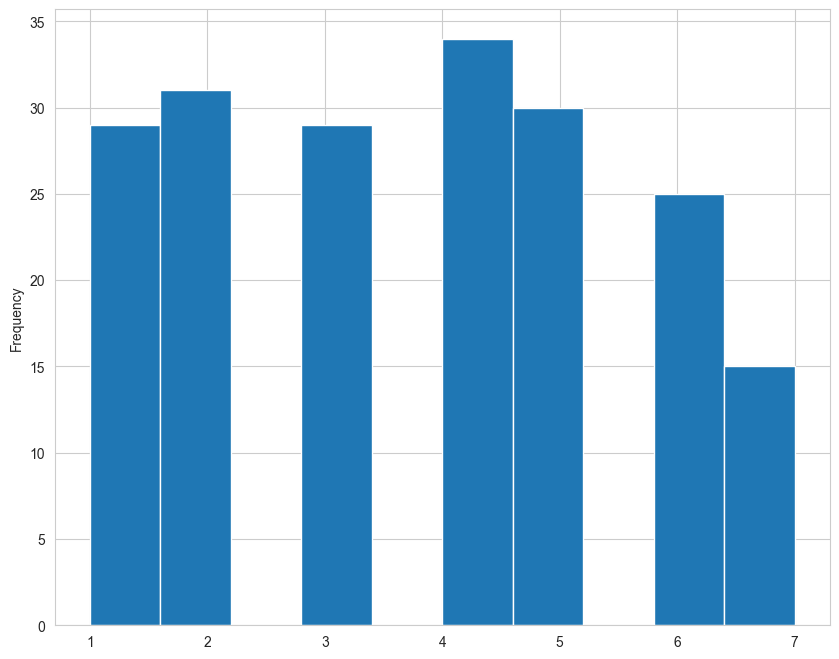

In [30]:
fraud_raw.Transaction_weekday.plot(kind='hist')

The distribution of fraudulent cases is different from the normal transactions. 12-13 o'clock see a peak in fraud and Sunday tend to have less frauds. Although normal transaction peaks on Friday, the fraud ones does not see a high volume on Friday.

### Feature engineering #5: Replace string with numeric values

These features are strings and we want to remove the strings and only look at the numeric values: AccountId, ProviderId, ProductId, ChannelId

In [31]:
train_raw['AccountId'] = train_raw['AccountId'].str.replace(r'\D', '').astype(int)
train_raw['ProviderId'] = train_raw['ProviderId'].str.replace(r'\D', '').astype(int)
train_raw['ProductId'] = train_raw['ProductId'].str.replace(r'\D', '').astype(int)
train_raw['ChannelId'] = train_raw['ChannelId'].str.replace(r'\D', '').astype(int)

With ProductCategory we assign numeric values as well:

In [32]:
train_raw.ProductCategory.unique()

array(['airtime', 'financial_services', 'utility_bill', 'data_bundles',
       'tv', 'transport', 'ticket', 'movies', 'other'], dtype=object)

In [33]:
train_raw.ProductCategory[train_raw.ProductCategory == 'airtime'] = 1
train_raw.ProductCategory[train_raw.ProductCategory == 'financial_services'] = 2
train_raw.ProductCategory[train_raw.ProductCategory == 'utility_bill'] = 3
train_raw.ProductCategory[train_raw.ProductCategory == 'data_bundles'] = 4
train_raw.ProductCategory[train_raw.ProductCategory == 'tv'] = 5
train_raw.ProductCategory[train_raw.ProductCategory == 'transport'] = 6
train_raw.ProductCategory[train_raw.ProductCategory == 'ticket'] = 7
train_raw.ProductCategory[train_raw.ProductCategory == 'movies'] = 8
train_raw.ProductCategory[train_raw.ProductCategory == 'other'] = 9

# Clean dataset for analysis

In [34]:
# List the columns for selection
train_raw.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'Value_cat',
       'trans_direction', 'fraud_history', 'Transaction_hour',
       'Transaction_weekday'],
      dtype='object')

In [35]:
# Select columns and copy into a new data frame
train = train_raw[['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy', 
'Value_cat', 'trans_direction', 'fraud_history', 'Transaction_hour', 'Transaction_weekday', 'FraudResult']].copy()

# Train-test-split & Metric

Before we start modeling we have to split our data into a train and test set and define a metric. We will choose a metric that takes precision and recall into account and evaluate our models using the f1-score.

In [36]:
# Define features and target variable
X = train.drop("FraudResult", axis=1)
y = train.FraudResult

In [37]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=RSEED)

# Baseline model

Before we start modeling we need to create a baseline model, which is basically an educated guess. From the scatter plot of the transaction value we can see that all transactions with value > 2,400,000 are fraudulent. As a simple baseline model we could assume that fraudulence is only related to the value and when value > 2,400,000 it is fraudulent and when value <= 2,400,000 it is not fraudulent. That is of course not completely correct but we only want to create a "baseline" that our more sophisticated models have to beat.

In [38]:
# Plotting is not so beautiful if we do not create a second axis for fraud cases
# sns.countplot(x="Value_cat", data=train, hue="FraudResult")

In [39]:
# Defining baseline model
def baseline_model(train):
    y_pred = [1 if val > 2400000 else 0 for val in train.Value]
    return y_pred

In [40]:
# Compute predictions with baseline model for test set
y_baseline_test = baseline_model(X_test)

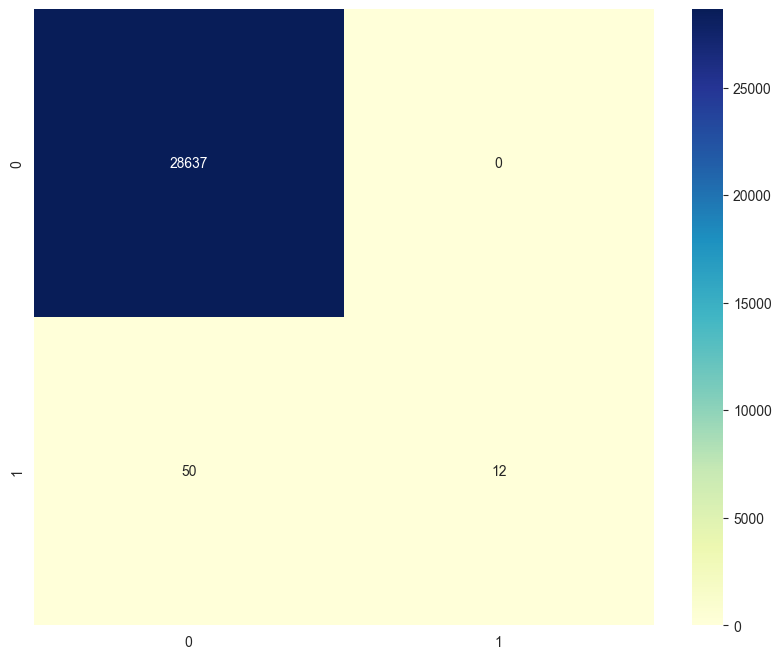

In [41]:
# Plot confusion matrix for baseline model
cm_base = confusion_matrix(y_test, y_baseline_test)
sns.heatmap(cm_base, cmap="YlGnBu", annot=True, fmt='d');

In [42]:
# Calculate f1-score for baseline model
print(classification_report(y_test, y_baseline_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28637
           1       1.00      0.19      0.32        62

    accuracy                           1.00     28699
   macro avg       1.00      0.60      0.66     28699
weighted avg       1.00      1.00      1.00     28699



For fraud cases, the accuracy is very high (1.0) but the recall is very low (0.19), so we have a low F-1 score of 0.32.

# Logistic regression

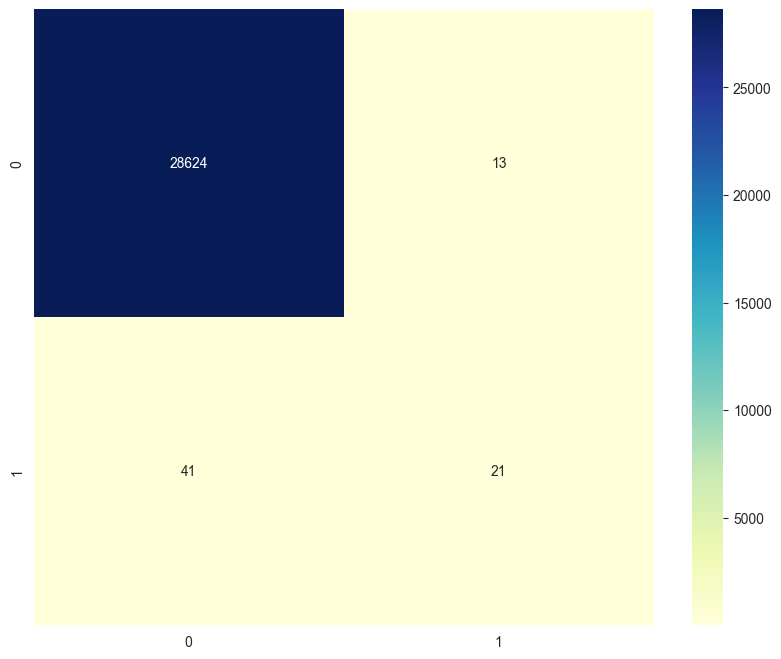

In [43]:
# Instantiate model and fit it on train data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions for test set
y_pred = logreg.predict(X_test)
cm_log = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_log, cmap="YlGnBu", annot=True, fmt='d');

In [44]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28637
           1       0.62      0.34      0.44        62

    accuracy                           1.00     28699
   macro avg       0.81      0.67      0.72     28699
weighted avg       1.00      1.00      1.00     28699



The F1 score improved from 0.32 to 0.44 with the logistic regression.

# Decision tree

In [45]:
# Creating the classifier object 
clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=3, min_samples_leaf=5)

# Performing training 
clf_gini.fit(X_train, y_train)  

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [46]:
# Decision tree with entropy 
clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth = 3, min_samples_leaf = 5) 
  
# Performing training 
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)

In [47]:
# Prediction on test with giniIndex 
y_pred_gini = clf_gini.predict(X_test)

print("Gini Report : \n", classification_report(y_test, y_pred_gini))

Gini Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28637
           1       1.00      0.74      0.85        62

    accuracy                           1.00     28699
   macro avg       1.00      0.87      0.93     28699
weighted avg       1.00      1.00      1.00     28699



In [48]:
# Prediction on test with entropyIndex 
y_pred_entropy = clf_entropy.predict(X_test)

print("Entropy Report : \n", classification_report(y_test, y_pred_entropy))

Entropy Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28637
           1       1.00      0.74      0.85        62

    accuracy                           1.00     28699
   macro avg       1.00      0.87      0.93     28699
weighted avg       1.00      1.00      1.00     28699



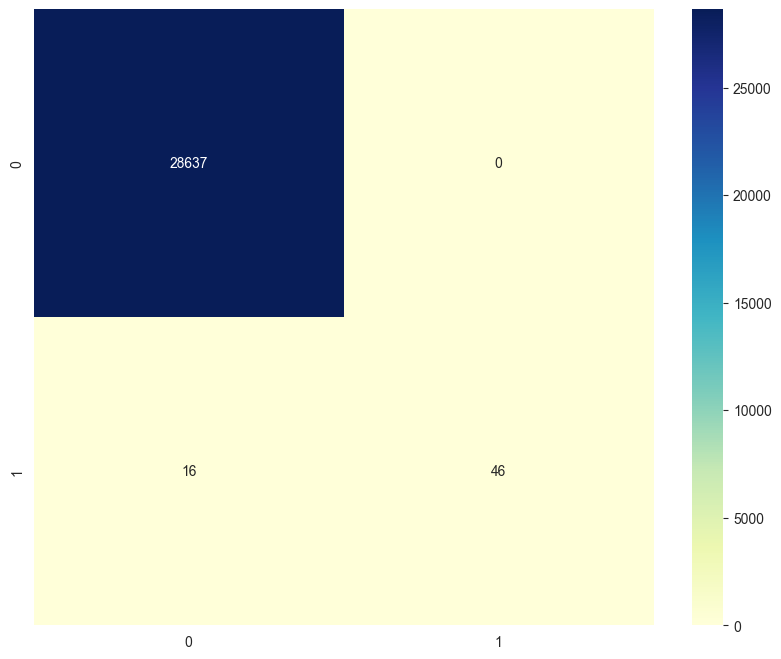

In [49]:
cm_gini = confusion_matrix(y_test, y_pred_gini)
sns.heatmap(cm_gini, cmap="YlGnBu", annot=True, fmt='d');

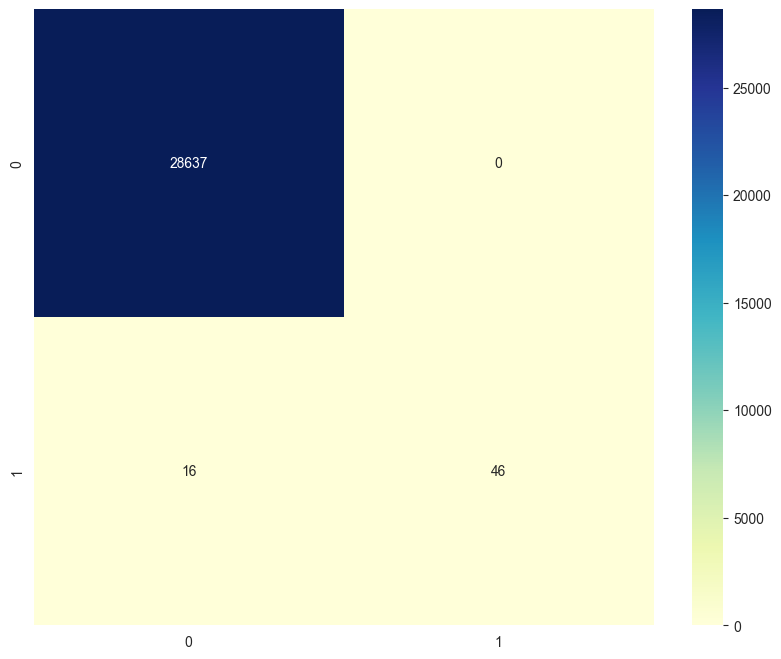

In [50]:
cm_entropy = confusion_matrix(y_test, y_pred_entropy)
sns.heatmap(cm_entropy, cmap="YlGnBu", annot=True, fmt='d');

The F1 score using both Gini and Entropy are 0.85 for the fraud cases, which is a big improvement. The precision is 1.0 and recall is 0.74 for the fraud cases which means that all of the fraud prediction are correct and we can predict 74% of all the fraud cases in the test dataset. 

# Random forest

In [51]:
rnc = RandomForestClassifier(n_estimators = 200)
rnc.fit(X_train, y_train)
y_pred_rf = rnc.predict(X_test)

In [52]:
print("Random Forest Report : \n", classification_report(y_test, y_pred_rf))

Random Forest Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28637
           1       0.94      0.82      0.88        62

    accuracy                           1.00     28699
   macro avg       0.97      0.91      0.94     28699
weighted avg       1.00      1.00      1.00     28699



The random forest result is even better - F1 score is improved to 0.88. Precision and recall for fraud are 0.94 and 0.82, respectively. It means that we can predict 82% of all the true fraud cases in the test data set and the precision of all predicted frauds that are truly frauds is 94%. 

# Dealing with imbalanced dataset

Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. Class imbalance can be found in many different areas including medical diagnosis, spam filtering, and fraud detection. In our case, we have a dataset of 95469 non-fraud cases and 193 fraud cases so the imbalance is quite severe.

## 1. Resampling Techniques — Oversample minority class

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with -- which is not our case but we will still try out.

In [53]:
# separate minority and majority classes
not_fraud = train[train.FraudResult==0]
fraud = train[train.FraudResult==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=RSEED) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.FraudResult.value_counts()

0    95469
1    95469
Name: FraudResult, dtype: int64

After resampling we have an equal ratio of data points for each fraud result! Let’s try our logistic regression again with the balanced training data.

In [54]:
# trying logistic regression again with the balanced dataset
y_train_upsample = upsampled.FraudResult
X_train_upsample = upsampled.drop('FraudResult', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train_upsample, y_train_upsample)

upsampled_pred = upsampled.predict(X_test)

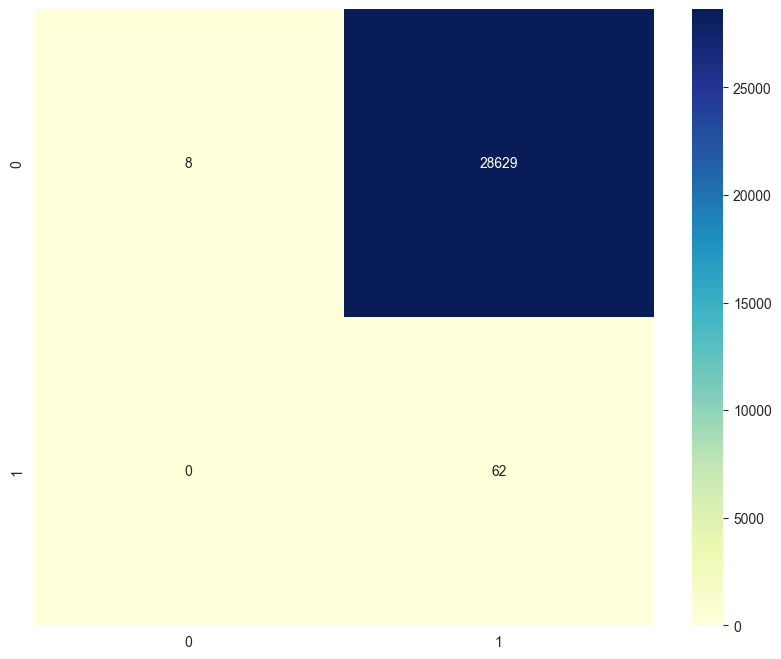

In [55]:
cm_upsample = confusion_matrix(y_test, upsampled_pred)
sns.heatmap(cm_upsample, cmap="YlGnBu", annot=True, fmt='d');

In [56]:
print("Upsampling Report : \n", classification_report(y_test, upsampled_pred))

Upsampling Report : 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     28637
           1       0.00      1.00      0.00        62

    accuracy                           0.00     28699
   macro avg       0.50      0.50      0.00     28699
weighted avg       1.00      0.00      0.00     28699



The F1 score is at 0 for fraud cases so oversampling minority class did not work well.

## 2.Resampling techniques — Undersample majority class

Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

In [65]:
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = RSEED) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.FraudResult.value_counts()

0    193
1    193
Name: FraudResult, dtype: int64

Again, we have an equal ratio of fraud to not fraud data points, but in this case a much smaller quantity of data to train the model on. Let’s again apply our logistic regression.

In [66]:
# trying logistic regression again with the downsampled dataset
y_train_downsample = downsampled.FraudResult
X_train_downsample = downsampled.drop('FraudResult', axis=1)

downsampled = LogisticRegression(solver='liblinear').fit(X_train_downsample, y_train_downsample)

downsampled_pred = downsampled.predict(X_test)

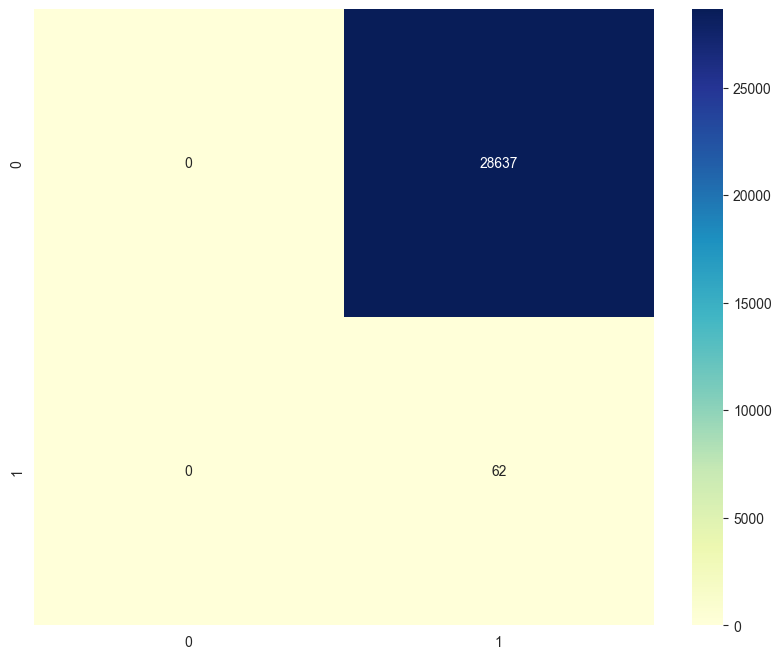

In [67]:
cm_downsample = confusion_matrix(y_test, downsampled_pred)
sns.heatmap(cm_downsample, cmap="YlGnBu", annot=True, fmt='d');

In [64]:
print("Downsampling Report : \n", classification_report(y_test, downsampled_pred))

Downsampling Report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     28637
           1       0.00      1.00      0.00        62

    accuracy                           0.00     28699
   macro avg       0.00      0.50      0.00     28699
weighted avg       0.00      0.00      0.00     28699

